# Random forest

In [121]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, plot_roc_curve, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score

from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('../data/raw/bank-additional.csv', delimiter=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Выделяем категориальные признаки и присваиваем им числовые значения

In [4]:
categorical_feature_mask = data.dtypes==object
categorical_cols = data.columns[categorical_feature_mask].tolist()

In [5]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [6]:
le = LabelEncoder()
data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))
data[categorical_cols].head(10)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,1,1,2,0,2,0,0,6,0,1,0
1,7,2,3,0,0,0,1,6,0,1,0
2,7,1,3,0,2,0,1,4,4,1,0
3,7,1,2,0,1,1,1,4,0,1,0
4,0,1,6,0,2,0,0,7,1,1,0
5,7,2,6,0,0,0,0,9,2,0,0
6,0,2,6,0,2,0,0,9,1,1,0
7,2,1,6,1,2,0,0,7,1,1,0
8,7,0,5,0,0,0,0,7,3,0,0
9,1,1,2,1,0,0,1,6,2,1,0


Проверка сбалансированности классов (наблюдается несбалансированность) -> для оценки качества лучше использовать balanced accuracy

In [7]:
X = data.iloc[:, :-1]
Y = np.array(data.iloc[:, -1:]).reshape(-1, )

In [8]:
sum(Y == 1)

451

In [9]:
sum(Y == 0)

3668

Делим выборку на трейновую и тестовую

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Для подбора лучших гиперпараметров пользуемся методом поиска по сетке Gridsearch

In [129]:
%%time
clf = RandomForestClassifier(n_jobs=8)
params = {
    "n_estimators": np.arange(1, 100, 10),
    "max_depth": np.arange(1, 100, 10),
    "min_samples_leaf": np.arange(1, 100, 10),
}
kf = StratifiedKFold(n_splits=5)
clf = GridSearchCV(estimator = clf,
                   param_grid = params, 
                   cv = kf,
                  scoring = "balanced_accuracy")
clf.fit(X_train, y_train)

Wall time: 17min 55s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=8),
             param_grid={'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'min_samples_leaf': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='balanced_accuracy')

In [110]:
print (clf.best_params_, clf.best_score_)

{'max_depth': 81, 'min_samples_leaf': 1, 'n_estimators': 81} 0.7312952198618177


Итого получаем:
* Максимальная глубина дерева: 81
* Минимальное кол-во обьектов в листе: 1
* кол-во деревьев: 81

Ниже сравниваем показатели balanced_accuracy_score и accuracy_score. Как и ожидается, balanced_accuracy_score ниже, чем accuracy_score.

In [130]:
%%time
params_ = {
    "n_estimators": 81,
    "max_depth": 81,
    "min_samples_leaf" :1,  
}

clf = RandomForestClassifier(**params_).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (balanced_accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred))

0.7010192837465565 0.899264705882353
Wall time: 256 ms


После применения PCA качество немного ухудшилось -> лучше использовать модель без применения PCA

In [74]:
pipe = Pipeline([('Std',StandardScaler()),('PCA', PCA(0.9)), ('Forest',RandomForestClassifier(**params_))])
pipe.fit(X_train, y_train) 

y_pred = pipe.predict(X_test)
print (balanced_accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred))

0.6450964187327823 0.9036764705882353


Посмотрим на другие метрики качества

# Roc curve

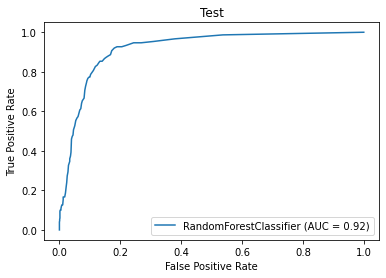

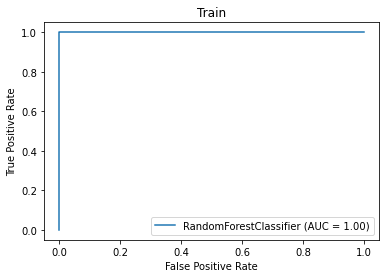

In [117]:
disp1 = plot_roc_curve(clf,X_test, y_test)
disp1.ax_.set_title("Test")
disp2 =plot_roc_curve(clf,X_train, y_train)
disp2.ax_.set_title("Train")
plt.show()

[]

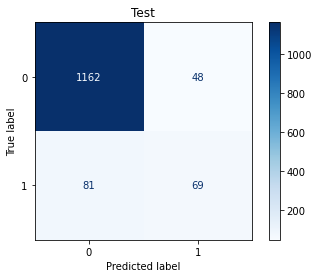

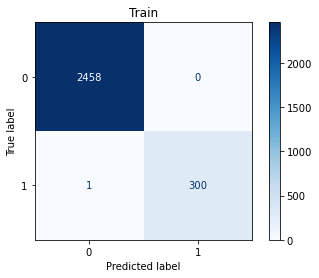

In [120]:
disp1 = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues)
disp1.ax_.set_title("Test")
disp2 = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues)
disp2.ax_.set_title("Train")
plt.plot()

In [127]:
print ("Precision score:", precision_score(y_test, y_pred, average = 'binary'))
print ("Recall score:", recall_score(y_test, y_pred, average = 'binary'))

Precision score: 0.5897435897435898
Recall score: 0.46


In [128]:
y_pred = clf.predict(X_train)
print ("Precision score train:", precision_score(y_train, y_pred, average = 'binary'))
print ("Recall score train:", recall_score(y_train, y_pred, average = 'binary'))

Precision score train: 1.0
Recall score train: 0.9966777408637874
